# Identifying the operation that caused the return of zero records 

In [25]:
import json
import os
import pandas as pd

from plotly.offline import init_notebook_mode
from sqlalchemy import create_engine

from query_flow.parsers.postgres_parser import PostgresParser
from query_flow.vizualizers.query_vizualizer import QueryVizualizer


# The following lines only needed for rendering in github
# and require conda install -c plotly plotly-orca psutil
import plotly.io as pio
pio.renderers.default = "png"

**Problems related to missing records are common and finding them tends to be hard for non-experts**. Using QueryFlow we can visualize the cardinality (actual_rows) of the query’s sub-expressions and find the first sub-expression that resulted in an empty result.  This problem can be caused due to either WHERE, JOIN, UNION, or HAVING clauses. In a similar way, we can solve the “why and why not problem”.


To show an example of identifying missing records, we introduce the following question in TPCH, “find all comedie movies with a few specific actors”. This question is equivalent to the SQL query in next cell, but to make it work without generating the database locally we will use a mock of the execution plan.

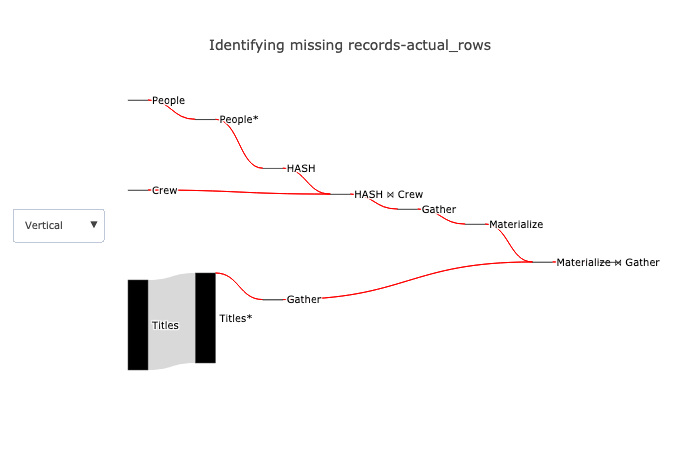

In [26]:
con_str = 'postgresql:///etrabelsi_thesis'
parser = PostgresParser()                                 
query_renderer = QueryVizualizer(parser)
query ="""
SELECT titles.title_id
FROM titles
INNER JOIN crew ON crew.title_id = titles.title_id
INNER JOIN people ON people.person_id = crew.person_id
WHERE genres like '%comedy%'
  AND name in ('Owen Wilson', 'Adam Sandler', 'Jason Segel')
"""

if os.environ.get("NOT_MOCK"):
    flow_df = query_renderer.get_flow_df(query, con_str)    
else:
    mock_path = f'../tests/parsers/data/postgres/parse/missing_records/execution_plan.json'
    flow_df = parser.parse([json.loads(open(mock_path).read())])

query_renderer.vizualize(flow_df, title="Identifying missing records", metrics=["actual_rows"], open_=False)

Using the Sankey visualization, we can see that we got an empty result set in the People* ⋈ Crew ⋈ Title* relation, and we can see the origin of the empty result in the Title* relation as it is red, and the Title link is gray. The people and crew are red due to postgresql optimization of predicate pushdown 